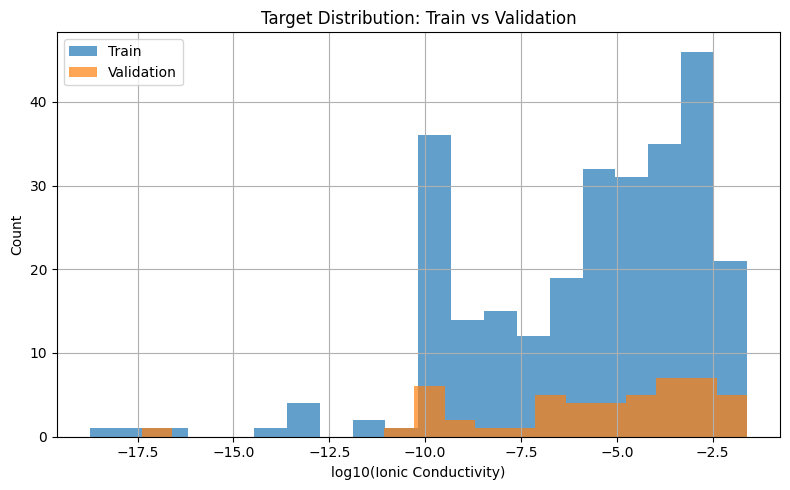

In [1]:
# Import cif_feat_apppend and cif_ic
import pandas as pd 

cif = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250623_Li_migration/data/cif_feat_append.csv')
ic = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250623_Li_migration/data/cif_ic.csv')

# log-scaling IC
import numpy as np
ic_log = np.log10(ic)

# Data split
## custom binning
bin_edges = [-np.inf, np.inf]
y_bins = pd.cut(ic_log.values.flatten(), bins=bin_edges, labels=False)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cif)

## train-test
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(cif, ic_log, test_size=0.15, random_state=42, stratify=y_bins)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=20, alpha=0.7, label='Train', color='tab:blue')
plt.hist(y_val, bins=20, alpha=0.7, label='Validation', color='tab:orange')
plt.xlabel('log10(Ionic Conductivity)')
plt.ylabel('Count')
plt.title('Target Distribution: Train vs Validation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# standardize the X dataset
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_sc = scaler_X.fit_transform(X_train)
X_val_sc = scaler_X.transform(X_val)

log_RMSE: 1.5090
log_R² Score: 0.7679
RMSE: 0.0039
R² Score: -0.0194


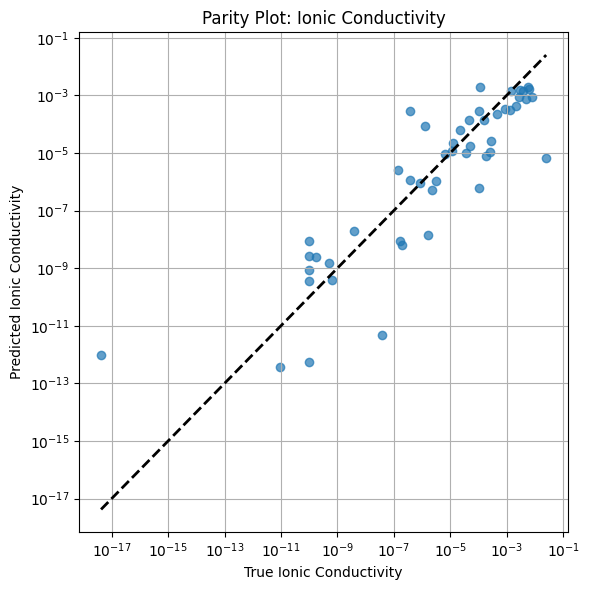

In [2]:
# xgb prediction model
from xgboost import XGBRegressor
# Compute metrics on actual IC scale
from sklearn.metrics import root_mean_squared_error, r2_score

model = XGBRegressor(n_estimators = 100, max_depth = 5, learning_rate = 0.1, n_jobs = -1)
model.fit(X_train_sc, y_train)

# Predict
y_pred_log = model.predict(X_val_sc)

rmse = root_mean_squared_error(y_val, y_pred_log)
r2 = r2_score(y_val, y_pred_log)

print(f"log_RMSE: {rmse:.4f}")
print(f"log_R² Score: {r2:.4f}")

# Inverse transform for evaluation
y_pred = 10**y_pred_log
y_true = 10**y_val

y_true = y_true.values.flatten()
y_pred = y_pred.flatten()

rmse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.xlabel("True Ionic Conductivity")
plt.ylabel("Predicted Ionic Conductivity")
plt.title("Parity Plot: Ionic Conductivity")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


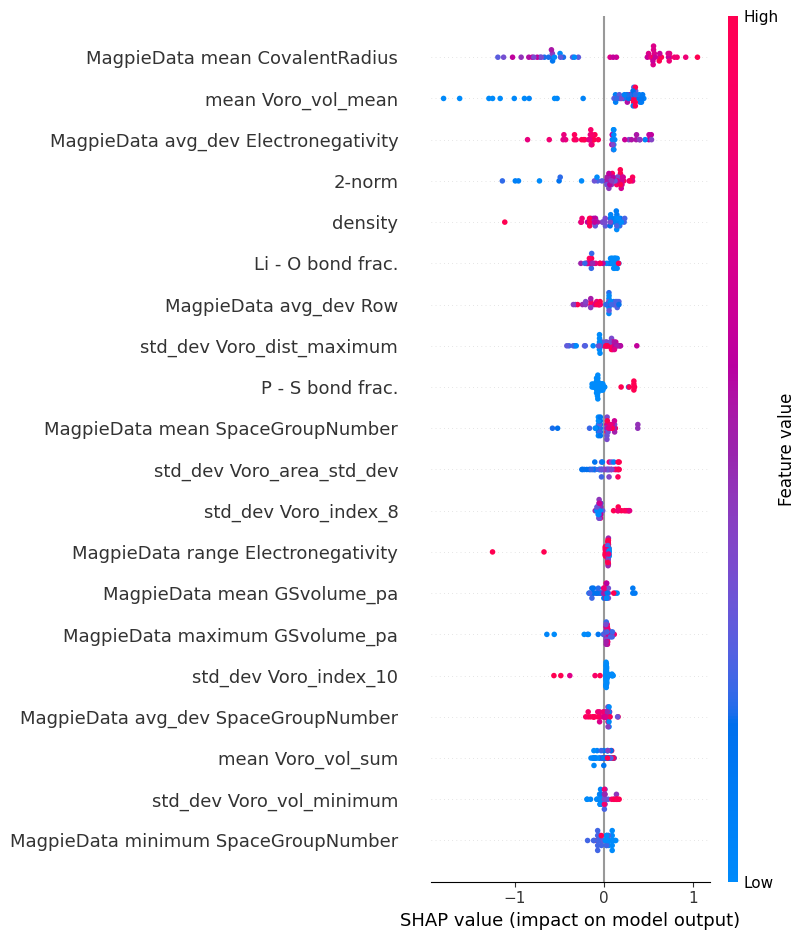

In [3]:
import shap

# Ensure X_val_sc is a DataFrame with column names
X_val_df = pd.DataFrame(X_val_sc, columns=X_train.columns)

# SHAP explainer for XGBoost
explainer = shap.Explainer(model, X_val_df)
shap_values = explainer(X_val_df)

# SHAP summary plot
shap.summary_plot(shap_values, X_val_df)

# Optional: Save summary plot
# import matplotlib.pyplot as plt
# plt.savefig("shap_summary_plot.png", bbox_inches='tight')


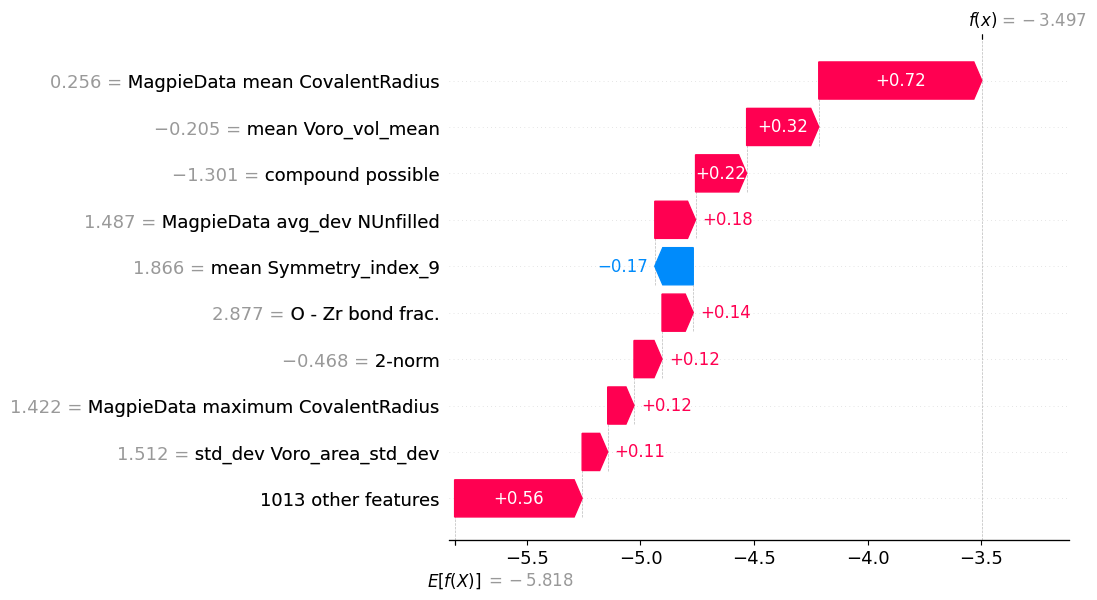

In [4]:
# Wrap the standardized input into a DataFrame if needed
X_val_df = pd.DataFrame(X_val_sc, columns=X_train.columns)

# Create the SHAP explainer
explainer = shap.Explainer(model, X_val_df)

# Compute SHAP values for all validation samples
shap_values = explainer(X_val_df)

# Plot waterfall for the i-th sample (e.g., 0)
i = 6
shap.plots.waterfall(shap_values[i])

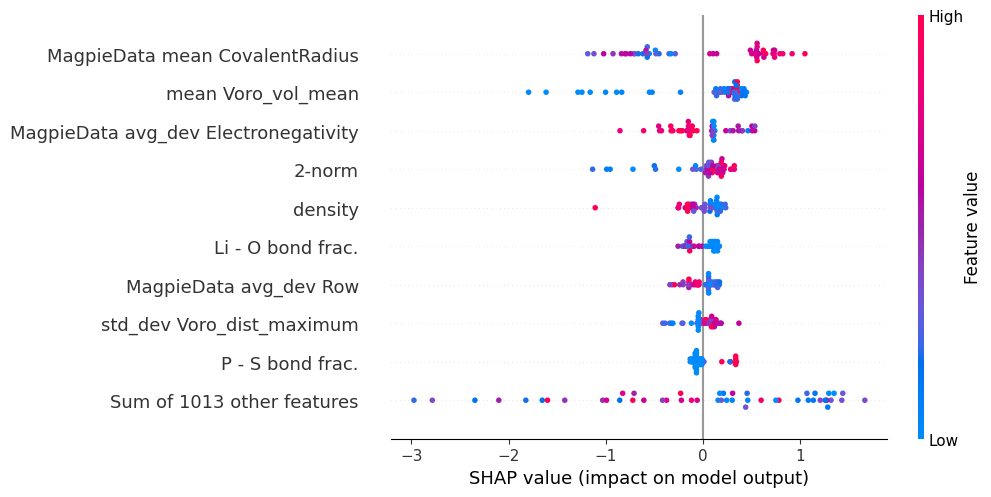

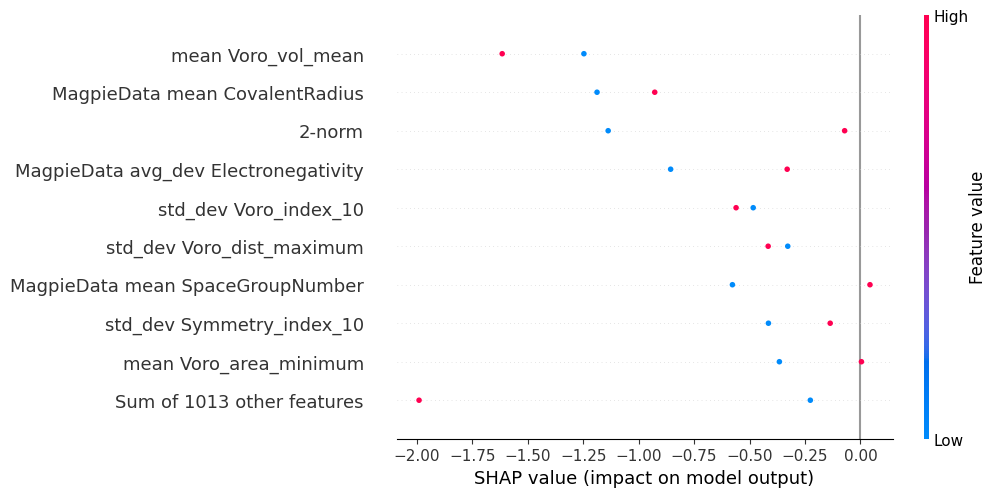

In [5]:
import shap
import pandas as pd
import numpy as np

# Restore X_val_sc as DataFrame with original feature names
X_val_sc_df = pd.DataFrame(X_val_sc, columns=X_val.columns)

# Initialize SHAP explainer with feature names
explainer = shap.Explainer(model, X_val_sc_df)
shap_values = explainer(X_val_sc_df)

# ✅ Optional: visualize full beeswarm with proper feature names
shap.plots.beeswarm(shap_values)

# Select subset: samples with very low ionic conductivity (log10 scale)
low_ic_idx = (y_val < -10).values.flatten()

# ✅ Plot SHAP beeswarm just for low IC samples
shap.plots.beeswarm(shap_values[low_ic_idx], max_display=10)


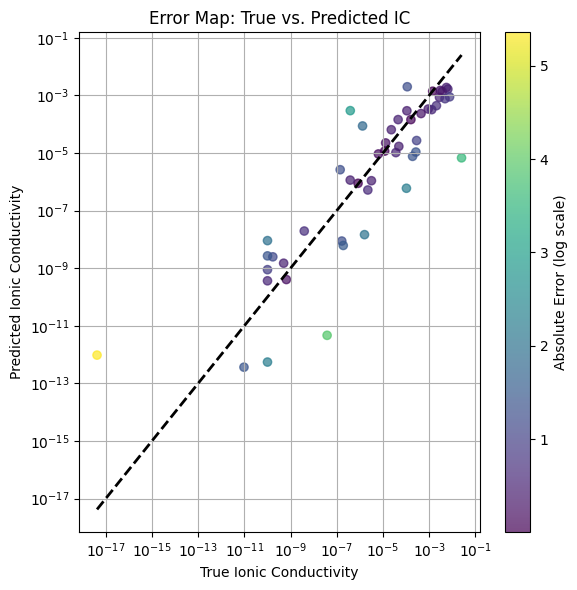

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure shapes match
errors = np.abs(y_val.values.flatten() - y_pred_log)

plt.figure(figsize=(6, 6))
plt.scatter(10**y_val.values.flatten(), 10**y_pred_log, c=errors, cmap='viridis', alpha=0.7)
min_val = min((10**y_val).min().item(), (10**y_pred_log).min())
max_val = max((10**y_val).max().item(), (10**y_pred_log).max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.xlabel("True Ionic Conductivity")
plt.ylabel("Predicted Ionic Conductivity")
plt.title("Error Map: True vs. Predicted IC")
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='Absolute Error (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()